In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import tensorflow as tf
#import  format_output
from datetime_extension import timedate_process
from produce_rnn_flow import aggregate_time
from math import sqrt

In [2]:
#read block data
df=pd.read_csv("blocks.csv",header=0)
#print(df.shape)
df=timedate_process(df)
df=aggregate_time(df)
df.head()


,Level,latBlock,lngBlock,month,day,h17,h3,h11,h8,h5,...,h15_neighbor2,h16_neighbor2,h17_neighbor2,h18_neighbor2,h19_neighbor2,h20_neighbor2,h21_neighbor2,h22_neighbor2,h23_neighbor2,days
0,0,0,20,4,1,0,0,0,0,0,...,24.5,80.0,20.0,3.0,1.0,1.0,1.0,1.0,0.0,0
1,0,0,20,4,2,0,0,0,0,0,...,16.0,16.5,35.5,2.5,1.5,1.5,2.0,1.5,0.5,1
2,0,0,20,4,3,1,0,0,0,0,...,34.0,4.5,7.5,8.5,1.5,1.5,1.5,1.5,0.5,2
3,0,0,20,4,5,1,0,0,0,0,...,6.5,30.5,29.5,0.0,4.5,44.5,21.5,14.5,31.5,4
4,0,0,20,4,6,0,0,0,0,0,...,16.5,28.5,9.0,12.5,5.5,9.0,1.5,1.5,0.5,5


In [3]:
#print(max(df[(level=='0')].latBlock))
#df=df[(df.Level==0) & (df.latBlock==0) & (df.lngBlock==20)]
df.drop(['Level','latBlock','lngBlock','month','day'], axis=1,inplace=True)
print(df)

        h17  h3  h11  h8  h5  h14  h4  h6  h18  h12  ...   h15_neighbor2  \
0         0   0    0   0   0    0   0   0    0    0  ...            24.5   
1         0   0    0   0   0    0   0   0    0    0  ...            16.0   
2         1   0    0   0   0    0   0   0    0    0  ...            34.0   
3         1   0    0   0   0    0   0   0    0    1  ...             6.5   
4         0   0    0   0   0    0   0   0    0    0  ...            16.5   
5         1   0    0   0   0    0   0   0    0    0  ...            10.0   
6         0   0    0   0   0    0   0   0    0    0  ...            19.0   
7         0   0    0   0   0    0   0   0    0    0  ...            17.0   
8         0   0    0   0   0    1   0   0    0    0  ...             4.0   
9         0   0    1   0   0    0   0   0    0    0  ...            10.0   
10        1   0    0   0   0    0   0   0    1    2  ...             9.5   
11        0   0    0   0   0    2   0   0    0    0  ...            17.5   
12        0 

In [4]:
data=[]
for i in range(0,len(df)):
    data.append(df.iloc[i].tolist())
data=np.array(data)

In [5]:
# define parameter
rnn_unit = 10  # hidden layer units
input_size = 73
output_size = 24
lr = 0.0006  # learning rate
N = 50 #ecope
N_model = 2 #each N time save model
length = 0
# ——————————————————input data——————————————————————
length=range(len(data))
#print(data)
# get train set
def get_train_data(batch_size=85, time_step=1, train_begin=0, train_end=length):
    batch_index = []
    data_train = data[train_begin:train_end]
    normalized_train_data = data_train
    #print(normalized_train_data)#
    train_x, train_y = [], []  # train set
    for i in range(len(normalized_train_data) - time_step):
        if i % batch_size == 0:
            batch_index.append(i)
        x = normalized_train_data[i:i + time_step, :73]
        y = normalized_train_data[i:i + time_step, 0:24]
        train_x.append(x.tolist())
        train_y.append(y.tolist())
    batch_index.append((len(normalized_train_data) - time_step))
    #print(train_y)
    return batch_index, train_x, train_y


# test set
def get_test_data(time_step=1, test_begin=0):
    data_test = data[test_begin:]
    mean = np.mean(data_test, axis=0)
    std = np.std(data_test, axis=0)

    normalized_test_data = data_test  # normalized
    size = (len(normalized_test_data) + time_step - 1) // time_step  # 
    test_x, test_y = [], []
    for i in range(size - 1):
        x = normalized_test_data[i * time_step:(i + 1) * time_step, :73]
        y = normalized_test_data[i * time_step:(i + 1) * time_step, 0:24]
        test_x.append(x.tolist())
        test_y.extend(y)
    test_x.append((normalized_test_data[(i + 1) * time_step:, :73]).tolist())
    test_y.extend((normalized_test_data[(i + 1) * time_step:, 0:24]).tolist())
    return mean, std, test_x, test_y




weights = {
    'in': tf.Variable(tf.random_normal([input_size, rnn_unit])),
    #'out': tf.Variable(tf.random_normal([rnn_unit, 1]))
    'out': tf.Variable(tf.random_normal([rnn_unit, output_size]))
}
biases = {
    'in': tf.Variable(tf.constant(0.1, shape=[rnn_unit, ])),
    #'out': tf.Variable(tf.constant(0.1, shape=[1, ]))
    'out': tf.Variable(tf.constant(0.1, shape=[output_size, ]))
}



def lstm(X):
    batch_size = tf.shape(X)[0]
    time_step = tf.shape(X)[1]
    w_in = weights['in']
    b_in = biases['in']
    input = tf.reshape(X, [-1, input_size])  
    input_rnn = tf.matmul(input, w_in) + b_in
    input_rnn = tf.reshape(input_rnn, [-1, time_step, rnn_unit]) 
    cell = tf.nn.rnn_cell.BasicLSTMCell(rnn_unit)
    init_state = cell.zero_state(batch_size, dtype=tf.float32)
    output_rnn, final_states = tf.nn.dynamic_rnn(cell, input_rnn, initial_state=init_state,
                                                 dtype=tf.float32)  
    output = tf.reshape(output_rnn, [-1, rnn_unit])  
    w_out = weights['out']
    b_out = biases['out']
    pred = tf.matmul(output, w_out) + b_out
    return pred, final_states



def train_lstm(batch_size=2, time_step=1, train_begin=0, train_end=10):
    X = tf.placeholder(tf.float32, shape=[None, time_step, input_size])
    Y = tf.placeholder(tf.float32, shape=[None, time_step, output_size])
    batch_index, train_x, train_y = get_train_data(batch_size, time_step, train_begin, train_end)
    with tf.variable_scope("sec_lstm"):
        pred, _ = lstm(X)

    loss = tf.reduce_mean(tf.square(tf.reshape(pred, [-1,output_size]) - tf.reshape(Y, [-1,output_size])))
    train_op = tf.train.AdamOptimizer(lr).minimize(loss)
    saver = tf.train.Saver(tf.global_variables(), max_to_keep=15)
    with tf.Session() as sess:
        try:
            module_file = tf.train.latest_checkpoint('.')
            saver.restore(sess, module_file)
        except:
            sess.run(tf.global_variables_initializer())
        # 重复训练N次
        for i in range(N):
            for step in range(len(batch_index) - 1):
                _, loss_ = sess.run([train_op, loss], feed_dict={X: train_x[batch_index[step]:batch_index[step + 1]],
                                                                 Y: train_y[batch_index[step]:batch_index[step + 1]]})
            #print(i, loss_)
            if i % N_model:
                print("save model：", saver.save(sess, '.\prediction.model', global_step=i))

train_lstm()






INFO:tensorflow:Restoring parameters from .\prediction.model-1
save model： .\prediction.model-1
save model： .\prediction.model-3
save model： .\prediction.model-5
save model： .\prediction.model-7
save model： .\prediction.model-9
save model： .\prediction.model-11
save model： .\prediction.model-13
save model： .\prediction.model-15
save model： .\prediction.model-17
save model： .\prediction.model-19
save model： .\prediction.model-21
save model： .\prediction.model-23
save model： .\prediction.model-25
save model： .\prediction.model-27
save model： .\prediction.model-29
save model： .\prediction.model-31
save model： .\prediction.model-33
save model： .\prediction.model-35
save model： .\prediction.model-37
save model： .\prediction.model-39
save model： .\prediction.model-41
save model： .\prediction.model-43
save model： .\prediction.model-45
save model： .\prediction.model-47
save model： .\prediction.model-49


In [6]:
def prediction(time_step=1,time_select=0):
    X = tf.placeholder(tf.float32, shape=[None, time_step, input_size])
    Y = tf.placeholder(tf.float32, shape=[None,time_step,output_size])
    mean, std, test_x, test_y = get_test_data(time_step)
    with tf.variable_scope("sec_lstm", reuse=True):
        pred, _ = lstm(X)
    saver = tf.train.Saver(tf.global_variables())
    with tf.Session() as sess:
        module_file = tf.train.latest_checkpoint('.')
        saver.restore(sess, module_file)
        
        
        test_predict = []
        for step in range(len(test_x) - 1):
            prob = sess.run(pred, feed_dict={X: [test_x[step]]})
            predict = prob.reshape((-1,1))
            test_predict.extend(predict)
        predict_test=[]
        for i in range(len(test_predict)):
            if i%24==time_select:
                predict_test.append(test_predict[i])
        #print(predict_test)
        y_test=[]
        test_y=np.array(test_y).reshape(-1,1)
        for i in range(len(test_y)):
            if i%24==time_select:
                y_test.append(test_y[i])
        test_y=np.array(y_test)
        test_predict=np.array(predict_test)
        test_y=np.nan_to_num(test_y)
        test_predict=np.nan_to_num(test_predict)
        test_y_result=[]
        test_predict_result=[]
        for i in test_y:
            test_y_result.append(i[0])
        for i in test_predict:
            test_predict_result.append(i[0])    
        test_predict_result=np.array(test_predict_result)
        test_y_result=np.array(test_y_result)
        result_list=[]
        #print(test_predict)
        for j in range(0,1936):
            target=[]
            prediction=[]
            target=test_y_result[j*85:(j+1)*85]
            prediction=test_predict_result[j*85:(j+1)*85]
            error = []
            #print(min(len(target),len(prediction)))
            for i in range(min(len(target),len(prediction))):
                error.append(target[i] - prediction[i])
            squaredError = []
            absError = []
            #print(error)
            for val in error:
                squaredError.append(val * val)#target-prediction之差平方 
                absError.append(abs(val))#误差绝对值
            #print(j)
            result_list.append(sqrt(sum(squaredError) / len(squaredError)))
        return result_list
        #print("RMSE = ", sqrt(sum(squaredError) / len(squaredError)))#均方根误差RMSE
        #plt.figure()
        #plt.plot(list(range(len(test_predict))), test_predict, color='b')
        #plt.plot(list(range(len(test_y))), test_y,  color='r')
        #plt.show()
RMSE_result=[]
for i in range(0,24):
    RMSE_result.append(prediction(1,i))

INFO:tensorflow:Restoring parameters from .\prediction.model-49
INFO:tensorflow:Restoring parameters from .\prediction.model-49
INFO:tensorflow:Restoring parameters from .\prediction.model-49
INFO:tensorflow:Restoring parameters from .\prediction.model-49
INFO:tensorflow:Restoring parameters from .\prediction.model-49
INFO:tensorflow:Restoring parameters from .\prediction.model-49
INFO:tensorflow:Restoring parameters from .\prediction.model-49
INFO:tensorflow:Restoring parameters from .\prediction.model-49
INFO:tensorflow:Restoring parameters from .\prediction.model-49
INFO:tensorflow:Restoring parameters from .\prediction.model-49
INFO:tensorflow:Restoring parameters from .\prediction.model-49
INFO:tensorflow:Restoring parameters from .\prediction.model-49
INFO:tensorflow:Restoring parameters from .\prediction.model-49
INFO:tensorflow:Restoring parameters from .\prediction.model-49
INFO:tensorflow:Restoring parameters from .\prediction.model-49
INFO:tensorflow:Restoring parameters fro

TypeError: object of type 'int' has no len()

In [7]:
rmseBlockRulst=[]
avg=0
for j in range(0,len(RMSE_result)):
    avg=0
    for i in RMSE_result:
        avg=avg+i[j]
    rmseBlockRulst.append(avg/24)
print(rmseBlockRulst)
print(max(rmseBlockRulst))

[0.5614510611370295, 3.9457362477121483, 18.878151222321453, 25.58673540942206, 2.951961489234882, 0.4766357574587152, 0.863287247044973, 4.02168966635621, 11.921874592652117, 23.06675066026979, 32.51452798039753, 9.56747554287036, 10.378926388773236, 0.6436659013739066, 0.3450382323170576, 0.44071292250684807, 0.6400871234945477, 1.0686649194168123, 4.897650898309291, 11.371406257324608, 22.85023979200875, 30.42253486438499, 15.512145939797165, 21.82828338773885]
32.51452798039753


In [38]:
r=[4.02168966635621,
 4.897650898309291,
 9.56747554287036,
 10.378926388773236,
 11.371406257324608,
 11.921874592652117,
 15.512145939797165,
 18.878151222321453,
 21.82828338773885,
 22.85023979200875,
 23.06675066026979,
 25.58673540942206]

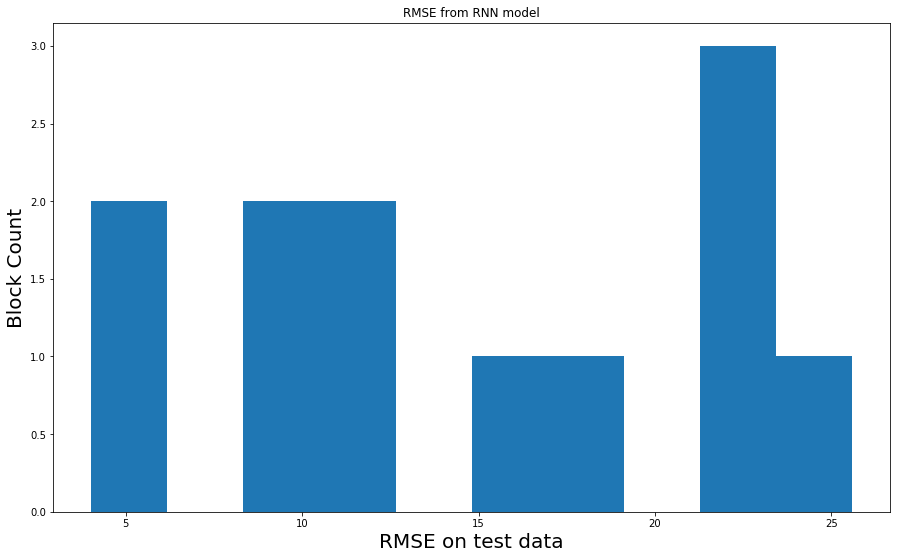

In [40]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,9))
plt.title("RMSE from RNN model")
plt.xlabel("RMSE on test data",size=20)
plt.ylabel("Block Count",size=20)
plt.hist(sorted(r))
plt.show()

In [37]:
np.mean(sorted(r)[10:22])

14.990110813153656

In [35]:
sorted(r)[10:22]

[4.02168966635621,
 4.897650898309291,
 9.56747554287036,
 10.378926388773236,
 11.371406257324608,
 11.921874592652117,
 15.512145939797165,
 18.878151222321453,
 21.82828338773885,
 22.85023979200875,
 23.06675066026979,
 25.58673540942206]